#Introducción

Este estudio evalúa el desempeño de tres modelos en la clasificación de emociones en español, utilizando un conjunto de datos de tweets etiquetados en siete categorías emocionales. Para asegurar una evaluación rigurosa y justa, se empleó el F1-score macro como métrica principal, debido a su idoneidad para conjuntos de datos desbalanceados. La investigación comparó arquitecturas de modelos basados en transformers preentrenados en español (Robertuito y Beto) con modelos de redes neuronales recurrentes (RNN), con el objetivo de identificar no solo el mejor rendimiento general, sino también analizar patrones de error, confusiones entre clases y el manejo del desbalanceo de datos. Los resultados obtenidos proporcionan insights valiosos sobre las limitaciones de los modelos para clasificar emociones minoritarias y ofrecen direcciones claras para futuras mejoras en el área.

#Carga de Datos

In [1]:
# Cargamos las librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Cargamos los datos
train_df = pd.read_csv('train.tsv', sep='\t')
dev_df = pd.read_csv('dev.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')

In [3]:
train_df

,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness
...,...,...,...,...,...
5718,c724c23b-2f6e-46f4-b740-0a7186349f60,Venezuela,"#Venezuela Querida, un dictador como Maduro so...",NO,others
5719,ee10fa89-f6ad-4f61-9bf7-d90604ce5b6b,NotreDame,#Notredame Impactantes imágenes que ha dejado ...,NO,sadness
5720,c0524970-cd8f-41a6-b9fa-ed052b23c297,Venezuela,¡ESCUCHA MADURO! Militares de #USA estarán ate...,NO,others
5721,f7b79584-d865-4e86-a83a-159792e98158,NotreDame,#NotreDame : 💔 💔 💔 Todo es efímero como el arc...,NO,others


#Exploración del Dataset

In [4]:
# Verificamos los datos cargados
print("Train shape:", train_df.shape)
print("Dev shape:", dev_df.shape)
print("Test shape:", test_df.shape)

Train shape: (5723, 5)
Dev shape: (844, 5)
Test shape: (1656, 5)


In [5]:
# Verificamos las columnas
train_df.columns

Index(['id', 'event', 'tweet', 'offensive', 'emotion'], dtype='object')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5723 entries, 0 to 5722
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5723 non-null   object
 1   event      5723 non-null   object
 2   tweet      5723 non-null   object
 3   offensive  5723 non-null   object
 4   emotion    5723 non-null   object
dtypes: object(5)
memory usage: 223.7+ KB


Verificamos nulos

In [7]:
train_df.isna().sum()

,0
id,0
event,0
tweet,0
offensive,0
emotion,0


In [8]:
test_df.isna().sum()

,0
id,30
event,30
tweet,30
offensive,30
emotion,0


Aquí podemos notar que hay datos NaN es el test_df, por lo que vamos a tratar este df más adelante.

In [9]:
dev_df.isna().sum()

,0
id,0
event,0
tweet,0
offensive,0
emotion,0


Vamos a realizar un conteo por cada emoción.

In [10]:
train_df['emotion'].value_counts()

,count
emotion,
others,2800
joy,1227
sadness,693
anger,589
surprise,238
disgust,111
fear,65


Se puede apreciar que es un dataset desbalanceado y que las clases bajos datos son "surprise", "disgust" y "fear".

Realizamos un conteo de cada evento.

In [11]:
train_df['event'].value_counts()

,count
event,
GameOfThrones,837
NotreDame,834
SpainElection,831
Venezuela,824
ChampionsLeague,813
WorldBookDay,775
GretaThunberg,416
LaLiga,393


Verificamos cuantos twits son ofensivos o no, se puede apreciar que la mayoría de tweets no lo son.

In [12]:
train_df['offensive'].value_counts()

,count
offensive,
NO,5253
OFF,470


Ahora vamos a verificar si existe alguna relación entre los mensajes ofensivos y  ciertas emociones como anger.

In [13]:
train_df[train_df['offensive'] == 'NO']

,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness
5,2c3c5661-a15e-4975-9e45-eeed3f89978a,ChampionsLeague,Bueno declaro Moscú la nueva y renovada Messig...,NO,others
...,...,...,...,...,...
5718,c724c23b-2f6e-46f4-b740-0a7186349f60,Venezuela,"#Venezuela Querida, un dictador como Maduro so...",NO,others
5719,ee10fa89-f6ad-4f61-9bf7-d90604ce5b6b,NotreDame,#Notredame Impactantes imágenes que ha dejado ...,NO,sadness
5720,c0524970-cd8f-41a6-b9fa-ed052b23c297,Venezuela,¡ESCUCHA MADURO! Militares de #USA estarán ate...,NO,others
5721,f7b79584-d865-4e86-a83a-159792e98158,NotreDame,#NotreDame : 💔 💔 💔 Todo es efímero como el arc...,NO,others


In [14]:
train_df[train_df['offensive'] == 'OFF']

,id,event,tweet,offensive,emotion
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness
12,32307a16-30d7-4a4c-b128-af6eae74f1c7,GameOfThrones,8 temporadas para que en un capítulo se echen ...,OFF,anger
15,3889a656-1b6b-4396-a231-694597bf1e6c,Venezuela,¿Cuánta mierda pueden tener en la cabeza los q...,OFF,anger
20,a099aec6-30d2-424a-b546-7e2f6b23ec6a,SpainElection,Ni perdiendo 71 escaños borra de su cara Pablo...,OFF,anger
40,a25c69f4-87e3-47d4-ab82-a224bc833743,ChampionsLeague,#ChampionsLeague USER apestas a campeon... Te ...,OFF,disgust
...,...,...,...,...,...
5685,201def35-4dca-45ef-9054-78ce854bd00a,Venezuela,"El rostro de una dictadura cobarde, que se esc...",OFF,anger
5687,1fa47e3a-8ff7-4deb-bd28-de55ba07bbcf,Venezuela,No metan al pueblo #Ruso es otro manipulado co...,OFF,anger
5688,af960f59-7c96-40ce-9a3e-7e4da3a157d0,Venezuela,Hasta donde llega la basura comunista???? Son ...,OFF,disgust
5713,2e12a872-f60a-4c2a-bc29-842fa41d4ec9,GameOfThrones,cómo cojones se supera este capítulo EH #juego...,OFF,surprise


In [15]:
train_df[train_df['offensive'] == 'OFF']['emotion'].value_counts()

,count
emotion,
anger,250
others,75
disgust,65
joy,47
surprise,23
sadness,8
fear,2


Como podemos visualizar en el cuadro todas las emociones están distribuidas en los mensajes ofensivos, o sea que no existe relación con alguna emoción en específico.

In [16]:
train_df.head()

,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness


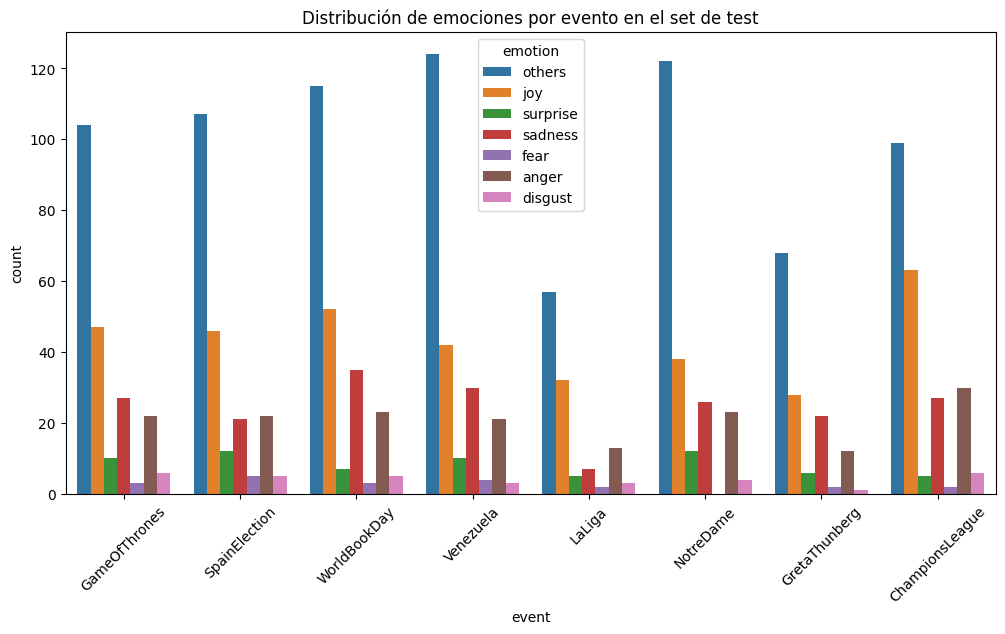

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x='event', hue='emotion', data=test_df)
plt.xticks(rotation=45)
plt.title('Distribución de emociones por evento en el set de test')
plt.show()

En este gráfico se observa la distribución de las emociones en cada evento. La emoción predominante es others, seguida de joy. En contraste, las emociones menos representadas son fear y disgust.

###Datos NaNs

Vamos a eliminar las filas con NaNs, como no son muchas hacemos un drop.

In [18]:
test_df.isna().sum()

,0
id,30
event,30
tweet,30
offensive,30
emotion,0


In [19]:
test_df = test_df.dropna()

In [20]:
test_df.isna().sum()

,0
id,0
event,0
tweet,0
offensive,0
emotion,0


#Clasificadores de emociones

In [21]:
# Importar librerías generales
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [22]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.7 MB/s eta 0:00:00


Dado que se cuenta con tres tipos de modelos con distintos enfoques de entrenamiento, se optó por realizar el preprocesamiento de los datos de manera específica para cada modelo, atendiendo a sus respectivas necesidades.

##RNN

In [22]:
# Importar librerías del modelo
import re
import emoji
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Preprocesamiento del texto

Para el modelo RNN se realizó una limpieza más dedicada del tecto, y el preprocesamiento basado en la tokenización de los textos y la conversión de las secuencias a índices numéricos. Posteriormente, se aplicó un proceso de padding para normalizar la longitud de las secuencias, garantizando así una representación uniforme de los datos de entrada.

In [23]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+", "<url>", texto)     # URLs → token
    texto = re.sub(r"@\w+", "<user>", texto)       # Menciones → token
    texto = re.sub(r"#(\w+)", r"\1", texto)        # #hashtag → palabra sin #
    texto = emoji.demojize(texto, delimiters=(" ", " "))  # 😭 → :cry:
    texto = re.sub(r"[^a-záéíóúñü\s:]", "", texto) # mantener tildes y :cry:
    texto = texto.strip()
    return texto

# Limpiar textos
train_df['clean_text'] = train_df['tweet'].apply(limpiar_texto)
dev_df['clean_text'] = dev_df['tweet'].apply(limpiar_texto)
test_df['clean_text'] = test_df['tweet'].apply(limpiar_texto)

In [24]:
# Codificamos etiquetas
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['emotion'])
dev_labels = label_encoder.transform(dev_df['emotion'])
test_labels = label_encoder.transform(test_df['emotion'])

# Convertir a one-hot
train_labels_cat = to_categorical(train_labels)
dev_labels_cat = to_categorical(dev_labels)
test_labels_cat = to_categorical(test_labels)

# Ver etiquetas
label_encoder.classes_

array(['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise'],
      dtype=object)

Tokenizar texto y crear secuencias

In [25]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['clean_text'])

# Convertir texto a secuencias
train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
dev_sequences = tokenizer.texts_to_sequences(dev_df['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])

# Padding
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
dev_padded = pad_sequences(dev_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [26]:
from sklearn.utils.class_weight import compute_class_weight # Para balancear pesos de clase

Definición del modelo

Con el objetivo de mejorar el desempeño del modelo RNN y considerando el desbalance de clases, así como la escasa cantidad de datos en algunas de ellas, se decidió emplear embeddings preentrenados. Para ello, se utilizaron las representaciones distribucionales en español proporcionadas por FastText:

In [30]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
!gunzip cc.es.300.vec.gz

--2025-09-01 19:47:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.59, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to: ‘cc.es.300.vec.gz’

cc.es.300.vec.gz    100%[===================>]   1.20G   162MB/s    in 13s     

2025-09-01 19:47:37 (95.9 MB/s) - ‘cc.es.300.vec.gz’ saved [1285580896/1285580896]



Asimismo, se instaló la librería Gensim para facilitar la carga y manejo de los vectores preentrenados.

In [31]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [29]:
from gensim.models import KeyedVectors
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding

In [30]:
fasttext_model = KeyedVectors.load_word2vec_format("cc.es.300.vec", limit=200000)
print("Dimensiones:", fasttext_model.vector_size)
print("Ejemplo vector de 'triste':", fasttext_model["triste"][:10])

Dimensiones: 300
Ejemplo vector de 'triste': [-0.0077 -0.0145 -0.0084 -0.0113  0.0582 -0.0093 -0.0145  0.0302 -0.013
 -0.0832]


Se construyó una matriz de embeddings preentrenados a partir de FastText, alineada con el vocabulario del Tokenizer. Cada palabra presente en FastText recibió su vector correspondiente, mientras que las no encontradas se representaron con ceros. Esta matriz inicializó la capa de Embedding en Keras, con trainable=False para mantener los vectores fijos durante el entrenamiento.

In [31]:
word_index = tokenizer.word_index   # diccionario palabra → índice
embedding_dim = fasttext_model.vector_size

In [32]:
# Creamos una matriz de ceros (tamaño: vocab_size x embedding_dim)
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:  # solo usamos las más frecuentes
        continue
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]
    else:
        # Si no está en FastText, se queda como vector de ceros
        pass

In [38]:
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False   # <- para no modificar los embeddings preentrenados
)

In [39]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [40]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 clases

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

El modelo inicia con una capa Embedding con vectores de FastText para representar las palabras. Luego, una capa Bidirectional LSTM captura dependencias contextuales de las secuencias. Posteriormente, una capa Dense con activación ReLU y regularización L2 extrae patrones más complejos, seguida de Dropout para reducir el sobreajuste. Finalmente, la capa Dense con softmax produce la probabilidad de las siete clases."

In [41]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,   # cuántas épocas sin mejorar antes de parar
    restore_best_weights=True
)

Se implementó EarlyStopping con el fin de detener el entrenamiento cuando la pérdida de validación deja de mejorar durante tres épocas consecutivas (patience=3). Además, se activó la opción restore_best_weights=True para conservar los pesos correspondientes al mejor desempeño del modelo

El modelo se compiló utilizando la función de pérdida categorical crossentropy, el optimizador Adam y la métrica de accuracy. Dado que los embeddings fueron congelados (trainable=False), el entrenamiento se centra únicamente en los parámetros de las capas superiores. El ajuste se llevó a cabo durante un máximo de 20 épocas, con un tamaño de lote de 64, empleando EarlyStopping para evitar el sobreajuste.

In [42]:
# Embeddings congelados
embedding_layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_1 = model.fit(
    train_padded, train_labels_cat,
    validation_data=(dev_padded, dev_labels_cat),
    epochs=20, batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 324ms/step - accuracy: 0.4389 - loss: 2.2737 - val_accuracy: 0.4905 - val_loss: 1.6375
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 322ms/step - accuracy: 0.4931 - loss: 1.6052 - val_accuracy: 0.4905 - val_loss: 1.4600
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - accuracy: 0.4941 - loss: 1.4555 - val_accuracy: 0.4917 - val_loss: 1.3843
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 315ms/step - accuracy: 0.4930 - loss: 1.3929 - val_accuracy: 0.5213 - val_loss: 1.3049
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 297ms/step - accuracy: 0.5172 - loss: 1.3352 - val_accuracy: 0.5438 - val_loss: 1.2463
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - accuracy: 0.5351 - loss: 1.2702 - val_accuracy: 0.5604 - val_loss: 1.2217
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 322ms/step - accuracy: 0.5534 - loss: 1.2472 - val_accuracy: 0.5758 - val_loss: 1.1927
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.5599 - loss: 1.2257 - val_accu

Realizamos la evaluación y métricas por el modelo.

In [43]:
# Evaluación
y_pred_probs = model.predict(test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels
f1_macro = f1_score(y_true, y_pred, average='macro')

report_dict_rnn1 = classification_report(
    y_true, y_pred, target_names=label_encoder.classes_, output_dict=True
)
# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
print(f"F1 Macro: {f1_macro:.6f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step
              precision    recall  f1-score   support

       anger       0.18      0.11      0.14       166
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.24      0.22      0.23       348
      others       0.50      0.66      0.57       796
     sadness       0.14      0.11      0.12       195
    surprise       0.00      0.00      0.00        67

    accuracy                           0.40      1626
   macro avg       0.15      0.16      0.15      1626
weighted avg       0.33      0.40      0.36      1626

F1 Macro: 0.151183


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

En esta etapa se procedió a descongelar la capa de embeddings con el objetivo de ajustar sus pesos durante el entrenamiento. Para evitar grandes actualizaciones que pudieran deteriorar el conocimiento preentrenado, se empleó un learning rate reducido (1e-4) mediante el optimizador Adam. El modelo se recompiló y se entrenó nuevamente durante un máximo de 10 épocas, manteniendo EarlyStopping como mecanismo de regularización

In [44]:
# Usar un learning rate más bajo
from tensorflow.keras.optimizers import Adam
fine_tune_lr = 1e-4
optimizer = Adam(learning_rate=fine_tune_lr)

In [45]:
# Descongelar embeddings
embedding_layer.trainable = True
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history_2 = model.fit(
    train_padded, train_labels_cat,
    validation_data=(dev_padded, dev_labels_cat),
    epochs=10, batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 731ms/step - accuracy: 0.6150 - loss: 1.0634 - val_accuracy: 0.6386 - val_loss: 1.0268
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 436ms/step - accuracy: 0.6490 - loss: 1.0122 - val_accuracy: 0.6481 - val_loss: 1.0136
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 651ms/step - accuracy: 0.6842 - loss: 0.9485 - val_accuracy: 0.6517 - val_loss: 0.9998
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 395ms/step - accuracy: 0.6808 - loss: 0.9205 - val_accuracy: 0.6445 - val_loss: 0.9975
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 356ms/step - accuracy: 0.6924 - loss: 0.9107 - val_accuracy: 0.6445 - val_loss: 1.0039
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 363ms/step - accuracy: 0.7199 - loss: 0.8690 - val_accuracy: 0.6445 - val_loss: 1.0120
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 375ms/step - accuracy: 0.7403 - loss: 0.7933 - val_accuracy: 0.6540 - val_loss: 1.0028


In [46]:
# Evaluación
y_pred_probs = model.predict(test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels
f1_macro = f1_score(y_true, y_pred, average='macro')

report_dict_rnn1 = classification_report(
    y_true, y_pred, target_names=label_encoder.classes_, output_dict=True
)
# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
print(f"F1 Macro: {f1_macro:.6f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step
              precision    recall  f1-score   support

       anger       0.15      0.14      0.14       166
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.23      0.17      0.20       348
      others       0.50      0.66      0.57       796
     sadness       0.14      0.12      0.13       195
    surprise       0.00      0.00      0.00        67

    accuracy                           0.39      1626
   macro avg       0.15      0.15      0.15      1626
weighted avg       0.32      0.39      0.35      1626

F1 Macro: 0.147964


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

En la primera fase, con los embeddings congelados, el modelo alcanzó una exactitud del 40% y un F1-macro de 0.15. Tras descongelar los embeddings y aplicar fine-tuning con una tasa de aprendizaje reducida, el rendimiento se mantuvo estable, con una exactitud del 39% y un F1-macro de 0.148. En ambos casos se observa que la clase others presenta los mejores resultados, mientras que las emociones minoritarias (disgust, fear y surprise) no logran ser reconocidas adecuadamente, lo cual refleja el impacto del desbalance de datos.

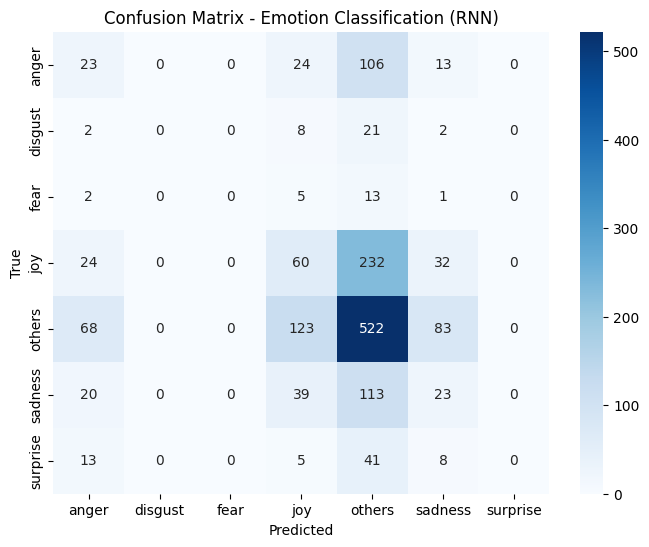

In [47]:
# Matriz de confusión
cm_rnn1 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rnn1, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Emotion Classification (RNN)')
plt.show()

La matriz de confusión muestra un desempeño sólido en la clase others, pero con alta confusión de las demás clases hacia esta. Las emociones minoritarias (disgust, fear y surprise) apenas logran ser reconocidas. Joy y sadness presentan un rendimiento intermedio, aunque también con frecuentes errores hacia others.

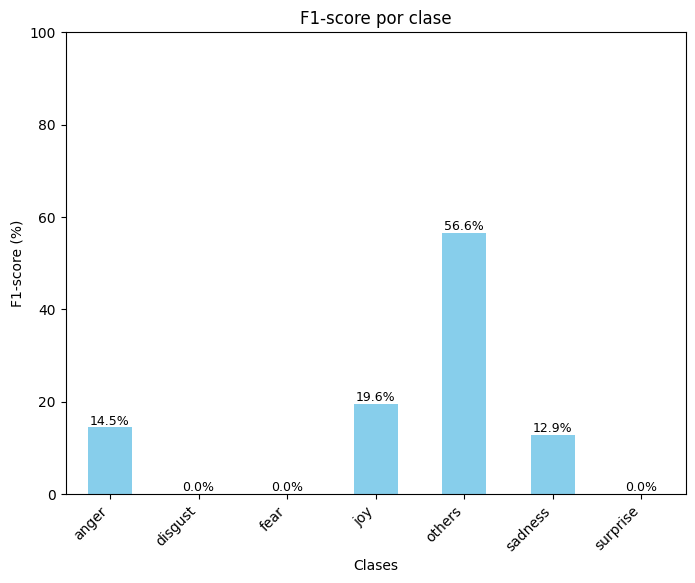

In [48]:
# Convertir a DataFrame
df_report = pd.DataFrame(report_dict_rnn1).transpose()

# Filtrar solo las clases (evitar 'accuracy', 'macro avg', 'weighted avg')
df_f1 = df_report.iloc[:-3, :][["f1-score"]]

# Convertir a porcentaje
df_f1 = df_f1 * 100

# Gráfico de barras verticales (solo F1)
ax = df_f1.plot(kind="bar", figsize=(8,6), legend=False, color="skyblue")
plt.title("F1-score por clase")
plt.ylabel("F1-score (%)")
plt.ylim(0, 100)
plt.xlabel("Clases")
plt.xticks(rotation=45, ha="right")

# Añadir etiquetas encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9)

plt.show()

##BETO

In [49]:
!pip install transformers datasets scikit-learn

In [50]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

En la etapa de preprocesamiento, las etiquetas de las emociones se normalizaron a minúsculas con el fin de unificar la representación textual. Posteriormente, se aplicó LabelEncoder para transformar las clases en valores numéricos, garantizando consistencia entre los conjuntos de entrenamiento, validación y prueba. Finalmente, se obtuvo el número total de clases a partir de las categorías identificadas.

In [51]:
# Etiquetas emociones en minúsculas
train_df['emotion'] = train_df['emotion'].str.lower()
dev_df['emotion'] = dev_df['emotion'].str.lower()
test_df['emotion'] = test_df['emotion'].str.lower()

label_encoder = LabelEncoder()
label_encoder.fit(train_df['emotion'])

train_labels = label_encoder.transform(train_df['emotion'])
dev_labels = label_encoder.transform(dev_df['emotion'])
test_labels = label_encoder.transform(test_df['emotion'])

num_labels = len(label_encoder.classes_)

print("Clases:", label_encoder.classes_)

Clases: ['anger' 'disgust' 'fear' 'joy' 'others' 'sadness' 'surprise']


En este Colab se utiliza el modelo BERT en español (dccuchile/bert-base-spanish-wwm-cased) para realizar clasificación de texto. Primero se carga el tokenizador, que convierte las frases en tokens que el modelo puede entender, y luego se carga el modelo de clasificación, adaptado para predecir la etiqueta correspondiente según el número de clases definido.

In [52]:
model_name = "dccuchile/bert-base-spanish-wwm-cased"

tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
def tokenize_function(examples):
    return tokenizer(examples['tweet'], truncation=True, padding='max_length', max_length=50)

train_encodings = tokenizer(list(train_df['tweet']), truncation=True, padding=True, max_length=50)
dev_encodings = tokenizer(list(dev_df['tweet']), truncation=True, padding=True, max_length=50)
test_encodings = tokenizer(list(test_df['tweet']), truncation=True, padding=True, max_length=50)

In [54]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
dev_dataset = TweetDataset(dev_encodings, dev_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [55]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [56]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nahyely-espinoza (nahyely-espinoza-universidad-nacional-de-san-antonio-aba) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [57]:
from transformers import EarlyStoppingCallback

En este bloque se configura y ejecuta el entrenamiento del modelo. Se establecen parámetros como el número de épocas, tamaño de los lotes, estrategias de evaluación y guardado, y la métrica para seleccionar el mejor modelo. Luego, con la clase Trainer, se entrena el modelo sobre el dataset de entrenamiento y se evalúa en cada época, guardando automáticamente el modelo que obtiene el mejor rendimiento.

In [58]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: nahyely-espinoza (nahyely-espinoza-universidad-nacional-de-san-antonio-aba) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.994300,0.848313,0.678910,0.660978,0.661554,0.678910
2,0.602900,0.868832,0.703791,0.686081,0.688972,0.703791
3,0.256300,1.089556,0.700237,0.690323,0.686915,0.700237
4,0.221800,1.553221,0.678910,0.676652,0.676821,0.678910
5,0.022000,1.873047,0.681280,0.675296,0.675466,0.681280
6,0.041800,1.958830,0.680095,0.675402,0.672572,0.680095


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2148, training_loss=0.36289920522597247, metrics={'train_runtime': 537.0534, 'train_samples_per_second': 63.938, 'train_steps_per_second': 4.0, 'total_flos': 882335255265000.0, 'train_loss': 0.36289920522597247, 'epoch': 6.0})

In [59]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)

print("Reporte de clasificación:\n")
report_dict_beto = classification_report(test_labels, preds, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(test_labels, preds, target_names=label_encoder.classes_))
f1_macro = f1_score(test_labels, preds, average='macro')
print(f"F1 macro: {f1_macro:.4f}")

Reporte de clasificación:

              precision    recall  f1-score   support

       anger       0.17      0.16      0.17       166
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.25      0.19      0.22       348
      others       0.50      0.59      0.54       796
     sadness       0.17      0.15      0.16       195
    surprise       0.05      0.04      0.05        67

    accuracy                           0.37      1626
   macro avg       0.16      0.16      0.16      1626
weighted avg       0.34      0.37      0.35      1626

F1 macro: 0.1618


Aquí podemos apreciar que el modelo logra una exactitud del 37%, pero su rendimiento varía mucho entre clases. Predice mejor la clase mayoritaria “others”, mientras que clases con pocos ejemplos, como “disgust” o “fear”, no se reconocen correctamente, al igual que en el anterior modelo. El F1 macro de 0.16 indica que, en promedio, el modelo aún tiene dificultades para clasificar de manera equilibrada todas las emociones. Esto sugiere que se necesitan más datos o estrategias para mejorar la predicción de las clases minoritarias.

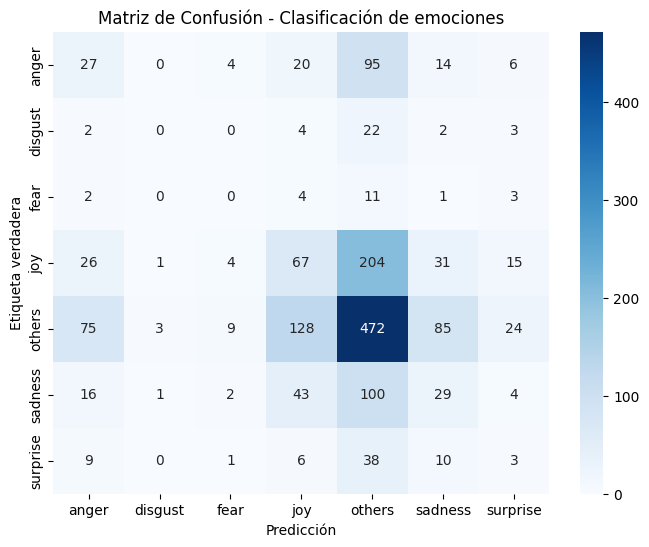

In [66]:
cm = confusion_matrix(test_labels, preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión - Clasificación de emociones')
plt.show()

La matriz muestra que el modelo predice principalmente la clase “others”, incluso cuando la etiqueta verdadera es otra emoción. Clases con pocos ejemplos como “disgust”, “fear” y “surprise” son confundidas mayoritariamente con “others” o con emociones similares. Esto confirma que el modelo tiene dificultades para diferenciar las emociones minoritarias y tiende a favorecer la clase mayoritaria.

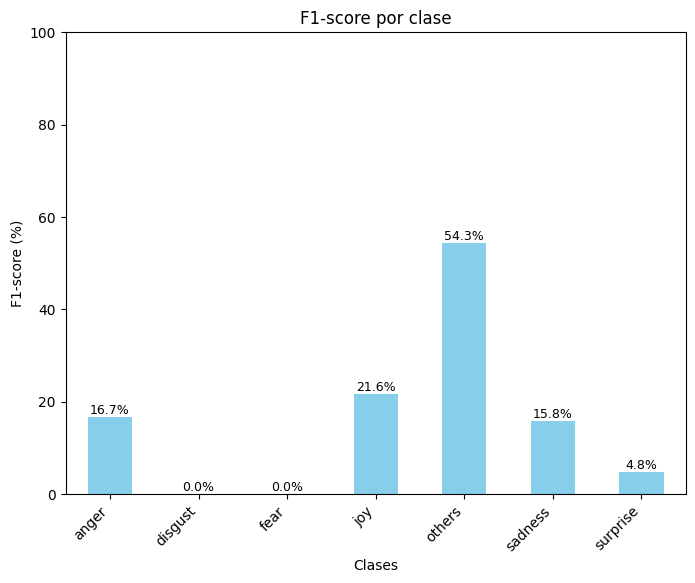

In [67]:
# Convertir a DataFrame
df_report = pd.DataFrame(report_dict_beto).transpose()

# Filtrar solo las clases (evitar 'accuracy', 'macro avg', 'weighted avg')
df_f1 = df_report.iloc[:-3, :][["f1-score"]]

# Convertir a porcentaje
df_f1 = df_f1 * 100

# Gráfico de barras verticales (solo F1)
ax = df_f1.plot(kind="bar", figsize=(8,6), legend=False, color="skyblue")
plt.title("F1-score por clase")
plt.ylabel("F1-score (%)")
plt.ylim(0, 100)
plt.xlabel("Clases")
plt.xticks(rotation=45, ha="right")

# Añadir etiquetas encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9)

plt.show()

##RoBERTuito

In [68]:
!pip install transformers datasets pysentimiento scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


En este segmento, configuramos las funciones esenciales de preprocesamiento y tokenización, utilizando las herramientas específicas del modelo Robertuito para asegurar la correcta interpretación del texto en español.

In [69]:
from pysentimiento.preprocessing import preprocess_tweet

def preprocess(text):
    return preprocess_tweet(text)

In [70]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-uncased")

def tokenize_function(examples):
    texts = [preprocess(t) for t in examples["tweet"]]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=128)


tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [71]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['tweet', 'id', 'event', 'offensive', 'emotion'])
dev_dataset = dev_dataset.map(tokenize_function, batched=True, remove_columns=['tweet', 'id', 'event', 'offensive', 'emotion'])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['tweet', 'id', 'event', 'offensive', 'emotion'])
train_dataset = train_dataset.add_column("labels", train_labels)
dev_dataset = dev_dataset.add_column("labels", dev_labels)
test_dataset = test_dataset.add_column("labels", test_labels)


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]

En este paso cargamos el modelo base preentrenado Robertuito y adaptamos su arquitectura para nuestra tarea específica de clasificación de emociones. Configuramos la capa final de clasificación con el número exacto de etiquetas emocionales que nuestro modelo debe predecir.

In [72]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "pysentimiento/robertuito-base-uncased",
    num_labels=len(label_encoder.classes_)
)

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

Aquí vamos a configurar el entrenamiento con una tasa de aprendizaje de 2e-5 para ajustar el modelo preentrenado de forma precisa, programando 5 épocas para maximizar el aprendizaje sin sobreajuste. El sistema evalúa automáticamente el rendimiento usando F1-score macro como métrica principal -crucial para manejar posibles desbalances entre clases- y guarda el mejor modelo tras cada evaluación. Finalmente, ejecutamos el fine-tuning y evaluamos los resultados del modelo optimizado.

In [73]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1_macro": f1, "precision_macro": precision, "recall_macro": recall}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
)

In [74]:
trainer.train()

eval_results = trainer.evaluate()
print(eval_results)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7782572507858276, 'eval_accuracy': 0.7274881516587678, 'eval_f1_macro': 0.4454320614171337, 'eval_precision_macro': 0.48506711798260477, 'eval_recall_macro': 0.4515559428745722, 'eval_runtime': 5.4064, 'eval_samples_per_second': 156.11, 'eval_steps_per_second': 9.803, 'epoch': 1.0}
{'loss': 0.8656, 'grad_norm': 5.448336124420166, 'learning_rate': 1.4424581005586593e-05, 'epoch': 1.3966480446927374}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7696765065193176, 'eval_accuracy': 0.7274881516587678, 'eval_f1_macro': 0.5095063208544254, 'eval_precision_macro': 0.6113803859031097, 'eval_recall_macro': 0.4939677156301398, 'eval_runtime': 5.3758, 'eval_samples_per_second': 157.0, 'eval_steps_per_second': 9.859, 'epoch': 2.0}
{'loss': 0.5198, 'grad_norm': 12.01659870147705, 'learning_rate': 8.837988826815643e-06, 'epoch': 2.793296089385475}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.834113359451294, 'eval_accuracy': 0.735781990521327, 'eval_f1_macro': 0.5573285672739953, 'eval_precision_macro': 0.5847034942728723, 'eval_recall_macro': 0.5531716094359792, 'eval_runtime': 5.3628, 'eval_samples_per_second': 157.38, 'eval_steps_per_second': 9.883, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9798945784568787, 'eval_accuracy': 0.707345971563981, 'eval_f1_macro': 0.5379118940509775, 'eval_precision_macro': 0.5413931558801953, 'eval_recall_macro': 0.5503030430499712, 'eval_runtime': 5.3555, 'eval_samples_per_second': 157.594, 'eval_steps_per_second': 9.896, 'epoch': 4.0}
{'loss': 0.3267, 'grad_norm': 14.164576530456543, 'learning_rate': 3.251396648044693e-06, 'epoch': 4.189944134078212}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0224766731262207, 'eval_accuracy': 0.7144549763033176, 'eval_f1_macro': 0.5386864788298257, 'eval_precision_macro': 0.552152815102494, 'eval_recall_macro': 0.5444561018233245, 'eval_runtime': 5.4223, 'eval_samples_per_second': 155.654, 'eval_steps_per_second': 9.774, 'epoch': 5.0}
{'train_runtime': 809.3264, 'train_samples_per_second': 35.357, 'train_steps_per_second': 2.212, 'train_loss': 0.517900021515745, 'epoch': 5.0}
{'eval_loss': 0.834113359451294, 'eval_accuracy': 0.735781990521327, 'eval_f1_macro': 0.5573285672739953, 'eval_precision_macro': 0.5847034942728723, 'eval_recall_macro': 0.5531716094359792, 'eval_runtime': 5.3738, 'eval_samples_per_second': 157.058, 'eval_steps_per_second': 9.863, 'epoch': 5.0}
{'eval_loss': 0.834113359451294, 'eval_accuracy': 0.735781990521327, 'eval_f1_macro': 0.5573285672739953, 'eval_precision_macro': 0.5847034942728723, 'eval_recall_macro': 0.5531716094359792, 'eval_runtime': 5.3738, 'eval_samples_per_second': 157.058, 'eval_step

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)

from sklearn.metrics import classification_report, f1_score

print(classification_report(test_labels, preds, target_names=label_encoder.classes_))
report_dict_robertuito=classification_report(test_labels, preds, target_names=label_encoder.classes_, output_dict=True)
f1_macro = f1_score(test_labels, preds, average='macro')
print(f"F1 macro: {f1_macro:.4f}")

              precision    recall  f1-score   support

       anger       0.18      0.23      0.20       166
     disgust       0.00      0.00      0.00        33
        fear       0.07      0.05      0.06        21
         joy       0.24      0.25      0.25       348
      others       0.53      0.53      0.53       796
     sadness       0.15      0.15      0.15       195
    surprise       0.05      0.03      0.04        67

    accuracy                           0.35      1626
   macro avg       0.17      0.18      0.17      1626
weighted avg       0.35      0.35      0.35      1626

F1 macro: 0.1737


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Como se puede apreciar, el modelo tiene un rendimiento bajo y desbalanceado (F1 macro: 0.17). Solo la clase mayoritaria "others" (53% F1) tiene un desempeño aceptable, mientras que las clases minoritarias como "disgust", "fear" y "surprise" tienen puntajes cercanos a cero. El modelo está sesgado hacia la clase dominante y falla en reconocer emociones con pocos ejemplos. Que nuevamente indica que se requiere balanceo de datos y estrategias para mejorar el aprendizaje de clases minoritarias.

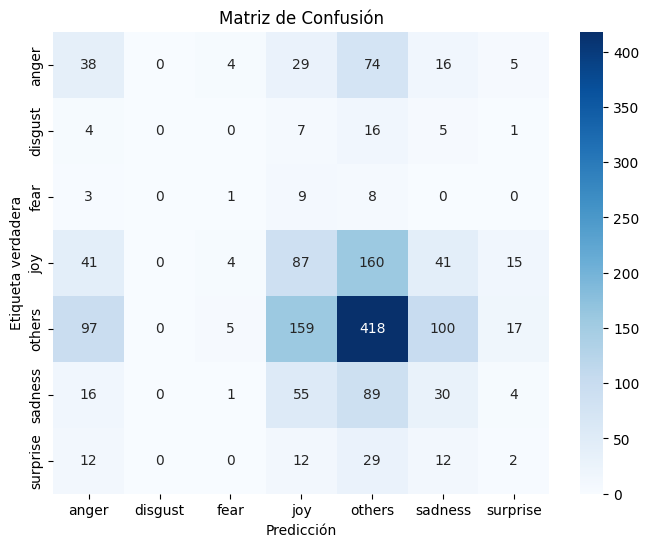

In [76]:
# Matriz de confusión
cm = confusion_matrix(test_labels, preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

En esta matriz de confusión podemos observar que "others" sigue siendo la clase con mayor cantidad de aciertos, confirmando el sesgo hacia la clase mayoritaria que identificamos en las métricas. Si bien con este modelo se logró predecir algunos casos de "fear" (lo cual representa un mínimo avance), no se acertó ningún caso de "disgust", reforzando la incapacidad del modelo para reconocer clases minoritarias.

El patrón más interesante revela que el modelo confunde frecuentemente las emociones "anger", "joy" y "sadness" con la clase "others". Esta confusión generalizada sugiere que el modelo está aprendiendo a utilizar "others" como una categoría comodín para casos donde no tiene seguridad suficiente, o donde las características distintivas de estas emociones no están siendo capturadas adecuadamente por el modelo actual.



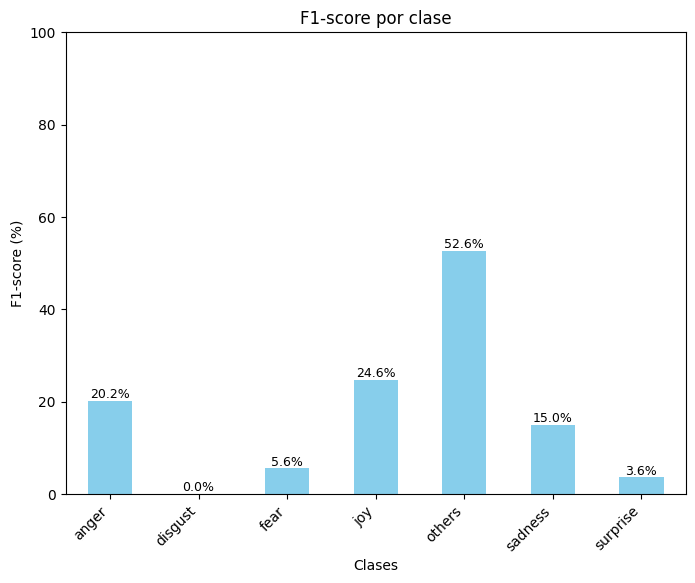

In [77]:
# Convertir a DataFrame
df_report = pd.DataFrame(report_dict_robertuito).transpose()

# Filtrar solo las clases (evitar 'accuracy', 'macro avg', 'weighted avg')
df_f1 = df_report.iloc[:-3, :][["f1-score"]]

# Convertir a porcentaje
df_f1 = df_f1 * 100

# Gráfico de barras verticales (solo F1)
ax = df_f1.plot(kind="bar", figsize=(8,6), legend=False, color="skyblue")
plt.title("F1-score por clase")
plt.ylabel("F1-score (%)")
plt.ylim(0, 100)
plt.xlabel("Clases")
plt.xticks(rotation=45, ha="right")

# Añadir etiquetas encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9)

plt.show()

#Evaluación de Resultados

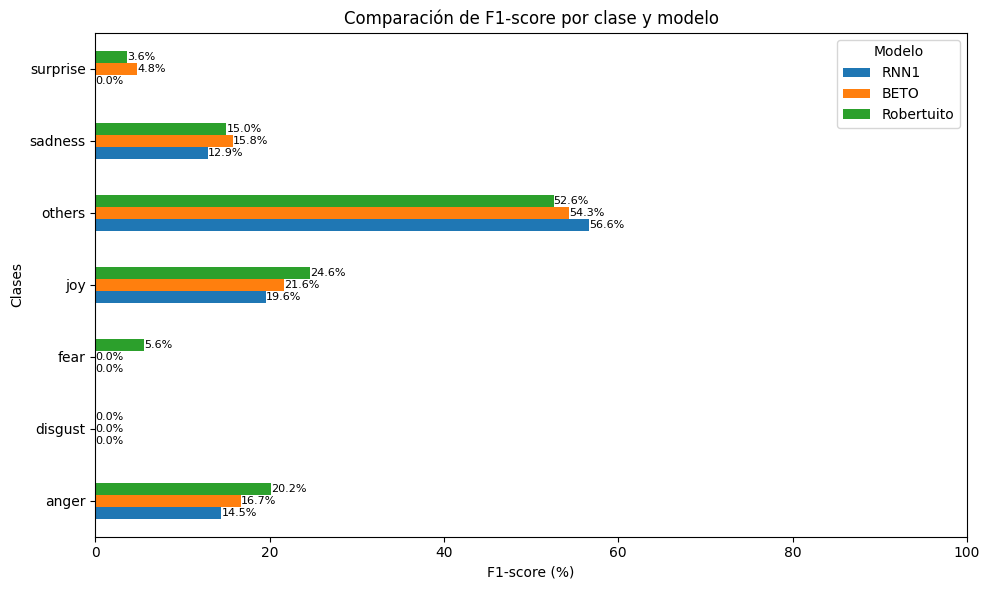

In [80]:
# Convertir a DataFrame cada reporte y quedarnos solo con F1-score
df_rnn1 = pd.DataFrame(report_dict_rnn1).transpose().iloc[:-3][["f1-score"]] * 100
df_beto = pd.DataFrame(report_dict_beto).transpose().iloc[:-3][["f1-score"]] * 100
df_robertuito = pd.DataFrame(report_dict_robertuito).transpose().iloc[:-3][["f1-score"]] * 100

# Renombrar columnas con el nombre del modelo
df_rnn1.rename(columns={"f1-score": "RNN1"}, inplace=True)
df_beto.rename(columns={"f1-score": "BETO"}, inplace=True)
df_robertuito.rename(columns={"f1-score": "Robertuito"}, inplace=True)

# Unirlos en un solo DataFrame
df_all = pd.concat([df_rnn1, df_beto, df_robertuito], axis=1)

# Gráfico de barras agrupadas
ax = df_all.plot(kind="barh", figsize=(10,6))
plt.title("Comparación de F1-score por clase y modelo")
plt.xlabel("F1-score (%)")
plt.ylabel("Clases")
plt.xlim(0, 100)
plt.legend(title="Modelo")

# Añadir etiquetas encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=8)

plt.tight_layout()
plt.show()


En este gráfico de comparación de F1-score por clase y modelo, se observa que el rendimiento varía significativamente entre modelos y emociones. La clase "others" obtuvo el mayor porcentaje (56.6%) con el modelo RNN1, mientras que en "joy" el mejor resultado fue de Robertuito (24.6%). Las clases minoritarias presentan graves deficiencias: todos los modelos fallaron por completo (0%) en "disgust", solo Robertuito logró un rendimiento mínimo en "fear" (5.6%), y en "surprise" el puntaje más alto fue de 4.8% con Beto. Estos resultados confirman que el problema central radica en el desbalanceo de los datos y la escasez de ejemplos en las clases minoritarias, lo que limita la capacidad de los modelos para aprender patrones representativos en estas categorías.

#Conclusiones

El análisis realizado evidencia que el principal desafío no reside en la selección del modelo, sino en la calidad y distribución de los datos. El rendimiento consistentemente bajo across todas las arquitecturas probadas —con un F1 macro de 0.17 y un accuracy del 35%— señala que el conjunto de datos presenta un desbalanceo crítico. La clase "others" domina abrumadoramente el dataset, acaparando la mayoría de los aciertos, mientras que emociones como "disgust", "fear" y "surprise" carecen de suficientes ejemplos para que los modelos aprendan sus patrones distintivos. Esta disparidad ha creado un sesgo inherente que perjudica el reconocimiento de las clases minoritarias.

Las confusiones más significativas se dan entre las emociones "anger", "joy" y "sadness" con la clase "others", indicando que los modelos han aprendido a utilizar esta última como una categoría comodín para casos inciertos. Este comportamiento refleja la dificultad de los algoritmos para generalizar a partir de muestras insuficientes y subraya la necesidad urgente de rebalancear el conjunto de datos. Resulta particularmente preocupante la incapacidad total de todos los modelos para predecir correctamente la emoción "disgust", así como los rendimientos ínfimos en "fear" y "surprise", que confirman que el problema fundamental es la escasez de datos representativos para estas clases.

Para abordar estas limitaciones, se recomienda prioritariamente implementar estrategias de aumento de datos y muestreo equilibrado para las clases minoritarias. Paralelamente, sería valioso revisar la calidad del etiquetado en las categorías conflictivas y considerar el uso de funciones de pérdida ponderadas que penalicen más los errores en las clases poco representadas. El camino hacia un modelo robusto no pasa por buscar arquitecturas más complejas, sino por construir una base de datos más balanceada y representativa que permita a cualquier algoritmo aprender las características distintivas de todas las emociones por igual.